# Time analysis
***



## Business understanding
De politiechef van Denver wil een goed overzicht krijgen van alle gebeurtenissen in een bepaalde tijdslot, zodat de politiechef hier in de toekomst op kan anticiperen.

### Determine business objectives
Het eerste wat uitgezocht moet worden is of er pieken of dalingen zijn in de specifieke misdaden.

### Determine data mining goals
Verkrijg alle benodigde data uit de dataset met behulp van datums en dit te vergelijking stellen met opvallende dalingen of pieken.

## Data understanding
***
De code hieronder zorgt dat de rest van het notebook werkt op zowel Mac als Windows. Dit is een cruciale stap om deze notebook werkend te maken.

In [7]:
import platform
import os

# Get working directory
working_directory = os.getcwd()

# check if macos
isMac = "macos" in platform.platform().lower()

### Collect initial data
Onderstaand halen wij de 2 verschillende datasets op die nodig zijn voor deze analyse.

In [8]:
crime_file_path = (f"{working_directory}/data/crime.csv" if isMac else f"{working_directory}\\data\\crime.csv")
offense_file_path = f"{working_directory}/data/offense_codes.csv" if isMac else f"{working_directory}\\data\\offense_codes.csv"

### Describe data
De data kan worden benaderd met de paden die in bovenstaande cell staan. Dit doen we door ze in een Pandas Dataframe te stoppen, zoals hieronder. Hierna kun je in dit hele Jupyter Notebook gebruik maken van de dataframes.

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta, MO
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Data in een dataframe te stoppen
crime_df = pd.read_csv(crime_file_path)
offense_df = pd.read_csv(offense_file_path)

### Explore data & Verify data quality
Voor verdere exploratie en verificatie, verwijs ik je graag naar de [algemene notebook](basic_data_understanding.ipynb).

## Data preparation
***
Als eerste gaan wij de data prepereren. Dit is nodig, omdat alle datums tot nu toe datums zijn met tijdsnotaties. Dit moeten wij eerst omzetten naar reguliere datums.

In [11]:
# Hier maken wij van de datum kolommen pandas readable DateTime kolommen om hier later makkelijker mee te kunnen werken.
crime_df["FIRST_OCCURRENCE_DATE"] = pd.to_datetime(crime_df["FIRST_OCCURRENCE_DATE"])
crime_df["LAST_OCCURRENCE_DATE"] = pd.to_datetime(crime_df["LAST_OCCURRENCE_DATE"])
crime_df["REPORTED_DATE"] = pd.to_datetime(crime_df["REPORTED_DATE"])

# Hier maken wij een nieuwe kolom van de `Reported Date` zonder de tijdsnotatie.
crime_df["REPORTED_DATE_NORMALIZED"] = crime_df["REPORTED_DATE"].dt.normalize()

### Select data
Selecteren is hierboven al gedaan.

***
## Job Story 1: Hoe vaak is er een hit & run gedaan?

# Business understanding
De politiechef heeft ons gevraagd om te kijken of er een grote stijging is met de aantal hit & run incidenten.

# Data preperation
Hiervoor gebruiken wij de `crime_df` dataset.

# Select data
Om te kunnen modelleren, hebben we een aantal gegevens nodig. Namelijk:
- Alle incidenten met de misdaad type `traffic-accident-hit-and-run`

In [12]:
# Om onafhankelijk aanpassingen te maken zijn nieuwe variabelen handig, vandaar een copy en een tag j1 (job story 1) aan het begin van het variabel
j1_crime_df = crime_df.copy()

In [23]:
# Tel alle incidenten op per datum van de Memorial days. Daarna voeg je de jaar toe als een kolom samen met de type.
j1_allhitandruns = j1_crime_df[j1_crime_df["OFFENSE_TYPE_ID"] == "traffic-accident-hit-and-run"]

j1_grouped = j1_allhitandruns.groupby("REPORTED_DATE_NORMALIZED", as_index=False).size()
j1_grouped.columns = ["Datum", "Aantal incidenten"]

j1_grouped

,Datum,Aantal incidenten
0,2017-01-02,9
1,2017-01-03,15
2,2017-01-04,14
3,2017-01-05,16
4,2017-01-06,25
...,...,...
1879,2022-02-24,24
1880,2022-02-25,19
1881,2022-02-26,14
1882,2022-02-27,20


# Modeling
Om de geprepareerde data in kaart te brengen is een barplot gebruikt om de aantallen te visualiseren.

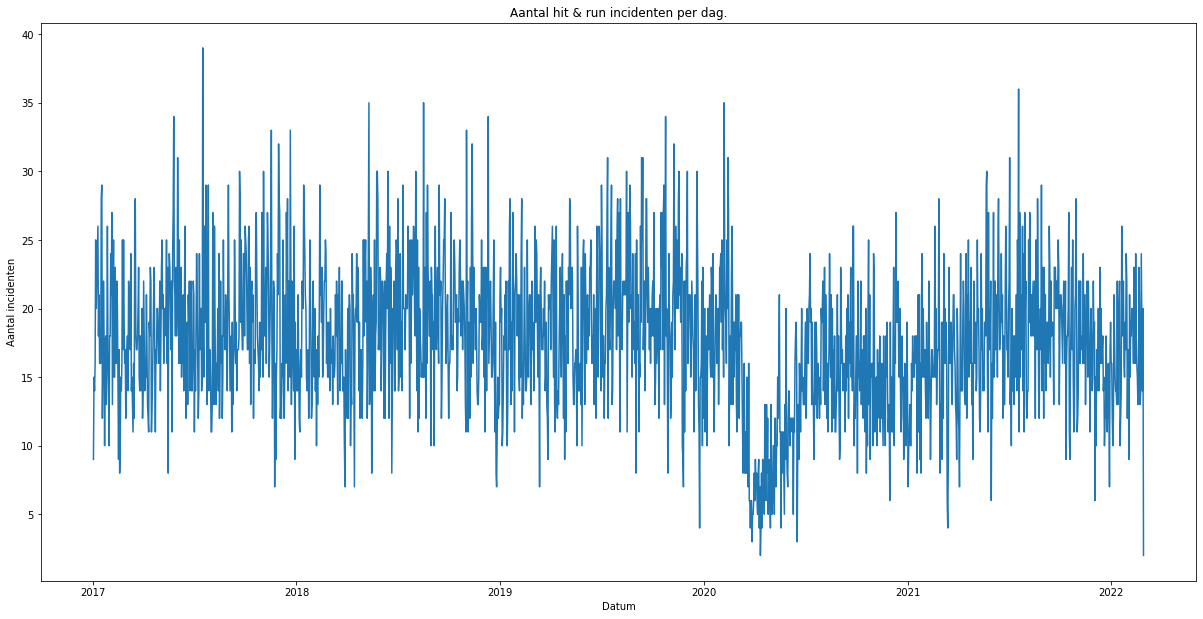

In [31]:
a4_dims = (20.7, 10.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(ax=ax, data=j1_grouped, x="Datum", y="Aantal incidenten", palette="rocket").set(title='Aantal hit & run incidenten per dag.')
plt.show()

Gezien aan de plot hierboven, zie je dat er tussen 2020 en 2021 erg weinig hit & runs zijn geweest vergeleken met de rest. Laten we daar dieper op in gaan

In [32]:
mask = (j1_grouped['Datum'] > '2020-1-1') & (j1_grouped['Datum'] <= '2021-1-1')

j1_zoomed = j1_grouped.loc[mask]

j1_zoomed

,Datum,Aantal incidenten
1095,2020-01-02,12
1096,2020-01-03,20
1097,2020-01-04,11
1098,2020-01-05,15
1099,2020-01-06,18
...,...,...
1456,2020-12-28,13
1457,2020-12-29,10
1458,2020-12-30,11
1459,2020-12-31,19


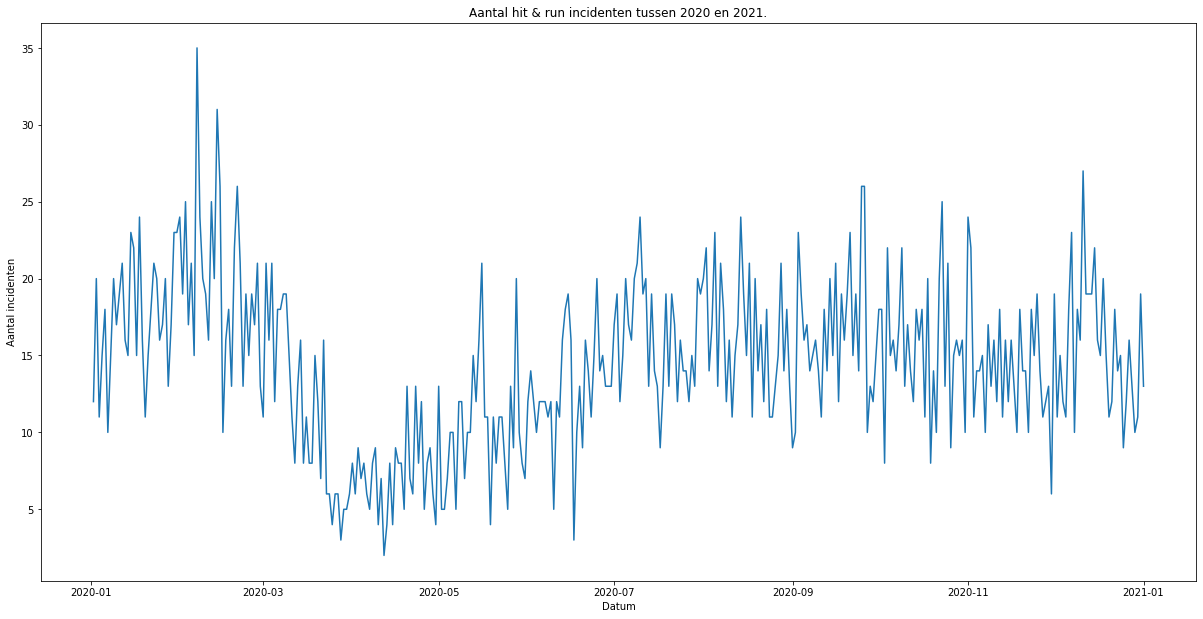

In [86]:
a4_dims = (20.7, 10.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(ax=ax, data=j1_zoomed, x="Datum", y="Aantal incidenten", palette="rocket").set(title='Aantal hit & run incidenten tussen 2020 en 2021.')
plt.show()

Gezien naar de plot hierboven is er inderdaad tussen Maart en Juli een stuk minder is. Laten we kijken of dit ook zo is met normale verkeers incidenten zijn.

In [84]:
# Tel alle incidenten op per datum van de Memorial days. Daarna voeg je de jaar toe als een kolom samen met de type.
j1_categorized = j1_crime_df[j1_crime_df["OFFENSE_TYPE_ID"].isin(["traffic-accident", "traffic-accident-hit-and-run", "theft-items-from-vehicle", "theft-parts-from-vehicle"])]
j1_categorized = j1_categorized.groupby(["OFFENSE_TYPE_ID", "REPORTED_DATE_NORMALIZED"], as_index=False).size()

mask = (j1_categorized['REPORTED_DATE_NORMALIZED'] > '2020-1-1') & (j1_categorized['REPORTED_DATE_NORMALIZED'] <= '2021-1-1')

j1_cat_zoomed = j1_categorized.loc[mask]

j1_cat_zoomed.columns = ["Categorie", "Datum", "Aantal incidenten"]
j1_cat_zoomed

,Categorie,Datum,Aantal incidenten
1095,theft-items-from-vehicle,2020-01-02,17
1096,theft-items-from-vehicle,2020-01-03,17
1097,theft-items-from-vehicle,2020-01-04,12
1098,theft-items-from-vehicle,2020-01-05,15
1099,theft-items-from-vehicle,2020-01-06,14
...,...,...,...
7099,traffic-accident-hit-and-run,2020-12-28,13
7100,traffic-accident-hit-and-run,2020-12-29,10
7101,traffic-accident-hit-and-run,2020-12-30,11
7102,traffic-accident-hit-and-run,2020-12-31,19


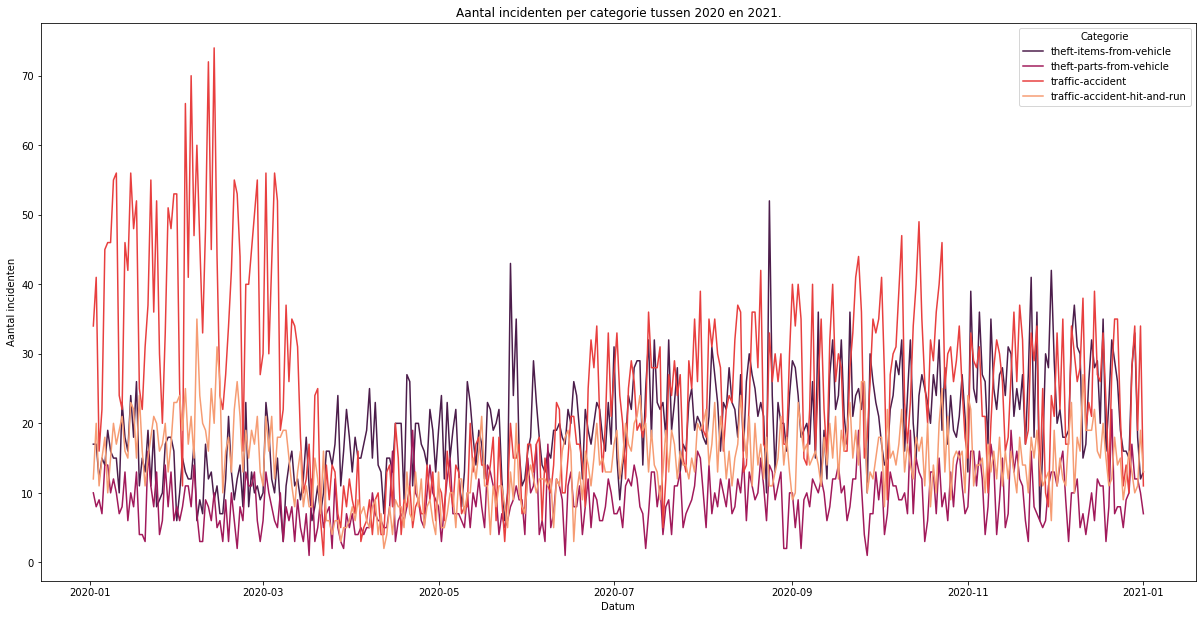

In [87]:
a4_dims = (20.7, 10.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(ax=ax, data=j1_cat_zoomed, x="Datum", y="Aantal incidenten", hue="Categorie", palette="rocket").set(title='Aantal incidenten per categorie tussen 2020 en 2021.')
plt.show()

Bovenstaand zien wij dat er inderdaad dat de normale verkeers incidenten ook verlaagd waren op dat punt.

Na wat zoeken kwam ik er achter dat op 19 maart 2020 [1 van de grootste sneeuwstormen was in Denver in 4 jaar](https://www.denverpost.com/2020/03/20/denver-weather-snowiest-day-four-years-march-19-2020/). Op dit moment begon ook de [Corona resticties te gelden die Denver had opgesteld](https://www.denverpost.com/2020/04/08/colorado-coronavirus-covid-timeline/).

Door deze 2 factoren zijn er minder mensen buiten geweest met de auto. Daarbij zijn ook de auto diefstallen minder geworden, voornamelijk het stelen van auto onderdelen.